In [5]:
from duration_processor import load_quiz_data
folder = '/Users/shiyihe/Desktop/USABILITY_ANALYSIS/tabular'
all_data = load_quiz_data(folder, ignore_completed=True)

## writing nlp

Correct answer length: 252
  format  avg_duration_sec  avg_similarity  avg_answer_length
0  hjson        315.165867        0.857548         247.600000
1   json        231.787706        0.986658         259.705882
2  json5        396.221917        0.758042         263.416667
3  jsonc        310.345067        0.977347         271.933333
4   toml        226.691429        0.957785         245.428571
5    xml        261.867429        0.886439         261.000000
6   yaml        410.872733        0.920769         277.000000


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_13077/1501161786.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


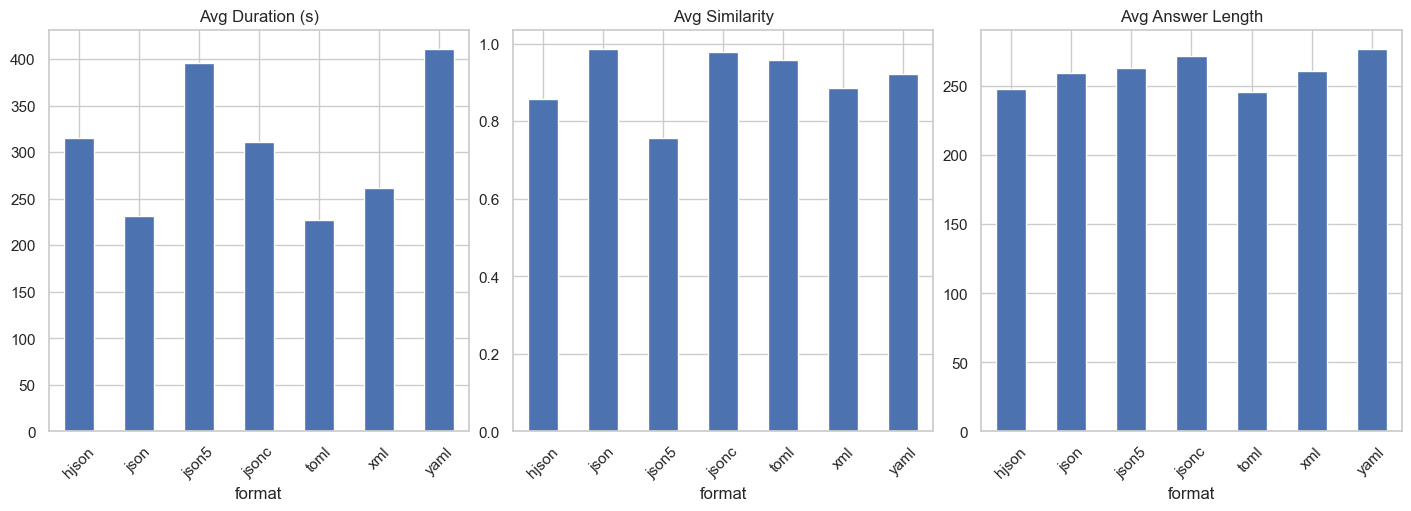

In [6]:
from writing_evaluator import (
    extract_writing_tasks,
    add_writing_metrics,
    get_correct_answer_length,
    summarize_writing_by_format,
    plot_writing_summary,
    extract_writing_tabular_tasks,
    plot_tabular_metrics_by_format
    # validate_tabular_syntax，
    # validate_strict_and_loose_syntax,
)

df_writing = extract_writing_tasks(all_data)

# 2. 定义正确答案
correct = (
    '"My life is very monotonous," the fox said. '
    '"I hunt chickens; men hunt me. All the chickens are just alike, '
    'and all the men are just alike. And, in consequence, '
    'I am a little bored. But if you tame me, '
    'it will be as if the sun came to shine on my life.'
)

# 3. 添加相似度和长度
df2 = add_writing_metrics(df_writing, correct)

# 4. 计算正确答案长度
correct_len = get_correct_answer_length(correct)
print("Correct answer length:", correct_len)

# 5. 汇总并可视化
summary = summarize_writing_by_format(df2)
print(summary)

fig = plot_writing_summary(summary)
fig.show()


In [8]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def test_format_differences(
    df: pd.DataFrame,
    metrics: list = None,
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    Compare the specified numeric metrics across different levels of `format_col`.

    For each metric, this function will:
      1. Coerce the column to numeric and drop missing values.
      2. Run Levene’s test for homogeneity of variances.
      3. If variances are homogeneous (p > alpha), run one-way ANOVA;
         otherwise run Kruskal–Wallis.
      4. If ANOVA is used and p < alpha, perform Tukey HSD post-hoc comparisons.
      5. Construct an English interpretation string.

    Args:
      df         DataFrame containing at least [format_col] + metrics
      metrics    List of column names to test; if None defaults to
                 ['duration_sec','answer_length','similarity']
      format_col Name of the grouping column (default 'format')
      alpha      Significance level (default 0.05)

    Returns:
      A dict mapping each metric to a dict with keys:
        'levene'        => (W_stat, p_levene)
        'method'        => 'ANOVA' or 'Kruskal–Wallis'
        'stat'          => F-statistic or H-statistic
        'p_value'       => p-value of the chosen test
        'tukey'         => TukeyHSDResults object (if ANOVA & significant), else None
        'interpretation'=> A human-readable summary sentence
    """
    if metrics is None:
        metrics = ['duration_sec', 'answer_length', 'similarity']

    results = {}
    for metric in metrics:
        if metric not in df.columns:
            print(f"⚠️ Column '{metric}' not found in DataFrame; skipping.")
            continue

        # 1. Coerce to numeric & drop missing rows
        series = pd.to_numeric(df[metric], errors='coerce')
        sub = pd.concat([df[format_col], series], axis=1).dropna()
        sub.columns = [format_col, metric]

        # Prepare one array per format
        groups = [g[metric].values for _, g in sub.groupby(format_col)]
        if len(groups) < 2:
            print(f"⚠️ Metric '{metric}' has fewer than 2 formats; skipping.")
            continue

        # 2. Levene’s test
        W, p_levene = levene(*groups)

        # 3. Choose test
        if p_levene > alpha:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
        else:
            # catch the “all identical” case in Kruskal
            try:
                stat, pval = kruskal(*groups)
            except ValueError:
                stat, pval = 0.0, 1.0
            method = 'Kruskal–Wallis'

        # 4. Tukey HSD if ANOVA & significant
        tukey = None
        if method == 'ANOVA' and pval < alpha:
            tukey = pairwise_tukeyhsd(
                endog=sub[metric],
                groups=sub[format_col],
                alpha=alpha
            )

        # 5. Build interpretation
        homogeneity = 'homogeneous' if p_levene > alpha else 'heterogeneous'
        var_msg = (f"Levene’s test for '{metric}': W = {W:.3f}, "
                   f"p = {p_levene:.3f} ({homogeneity} variances).")
        if pval < alpha:
            main_msg = (f"{method}: statistic = {stat:.3f}, p = {pval:.3f} (< {alpha}), "
                        "formats differ significantly.")
            if tukey is not None:
                main_msg += " See Tukey HSD for pairwise comparisons."
        else:
            main_msg = (f"{method}: statistic = {stat:.3f}, p = {pval:.3f} (≥ {alpha}), "
                        "no significant differences between formats.")

        interpretation = var_msg + " " + main_msg

        results[metric] = {
            'levene':        (W, p_levene),
            'method':        method,
            'stat':          stat,
            'p_value':       pval,
            'tukey':         tukey,
            'interpretation': interpretation
        }

    return results

results = test_format_differences(df2)

for metric, info in results.items():
    print(f"\n=== Metric: {metric} ===")
    print(info['interpretation'])
    if info['tukey'] is not None:
        print(info['tukey'].summary())



=== Metric: duration_sec ===
Levene’s test for 'duration_sec': W = 2.202, p = 0.049 (heterogeneous variances). Kruskal–Wallis: statistic = 4.936, p = 0.552 (≥ 0.05), no significant differences between formats.

=== Metric: answer_length ===
Levene’s test for 'answer_length': W = 1.099, p = 0.369 (homogeneous variances). ANOVA: statistic = 1.403, p = 0.222 (≥ 0.05), no significant differences between formats.

=== Metric: similarity ===
Levene’s test for 'similarity': W = 2.437, p = 0.031 (heterogeneous variances). Kruskal–Wallis: statistic = 7.845, p = 0.250 (≥ 0.05), no significant differences between formats.


## writing tabular helpclick stat

Summary by format:
  format  avg_duration_sec  avg_help_clicks
0  hjson        592.194800         2.600000
1   json        812.642647         7.000000
2  json5        781.481167         3.166667
3  jsonc        800.959867         3.200000
4   toml        573.356357         3.857143
5    xml        785.486357         3.642857
6   yaml        622.835133         3.333333


/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_13077/84471301.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_dur.show()
/var/folders/hs/htjkkv116fv94g1llc3jj8jc0000gn/T/ipykernel_13077/84471301.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_help.show()


,participantId,format,code,startTime,endTime,duration_sec,helpButtonClickedCount
0,6697c8b6d9d7baa7edd8c4d3,hjson,patients: [\n {\n name: John\n ...,1745932567200,1745933142854,575.654,0
1,67e25388d573ec2d5f1c8442,yaml,person:\n name: John\ntests\n # id:1\n norm...,1746146837797,1746147375040,537.243,2
2,67e5cf90b79d0874e1cf16b0,toml,"[patients]\n[[patients.patient]]\nname = ""John...",1746145745579,1746146463120,717.541,2
3,67d00f24466a67ba7e41228e,toml,"[[patients]]\n[[users]]\nname = ""john""\n[tests...",1745930601970,1745932342937,1740.967,11
4,66475d6f7b27e4443ef0d031,json,{\n patients\n if(name)=John\n then{\...,1744921480385,1744921734203,253.818,0
5,6672d878f68b9e349b56e871,toml,name='John'test= Id=1 Results=Normal Id=2 Name...,1746144856654,1746145373859,517.205,0
6,67f5bb69760b211cdfe8021c,jsonc,"{\n ""patients"" : {\n ""name"" : ""john""...",1746150048109,1746150828548,780.439,0
7,67e571bef6af7ecd9c29ad72,json,"{\n ""patients"" : [\n {\n ""name""...",1746146822874,1746147358937,536.063,0
8,60f1f1d4ac991a259b83f603,json,Note: Different colors represent different lev...,1746232143082,1746232546737,403.655,0
9,678f0bb28ec3307e4f1afb78,hjson,{patient\n name: John\n tests: \n ...,1746145002506,1746145881479,878.973,6


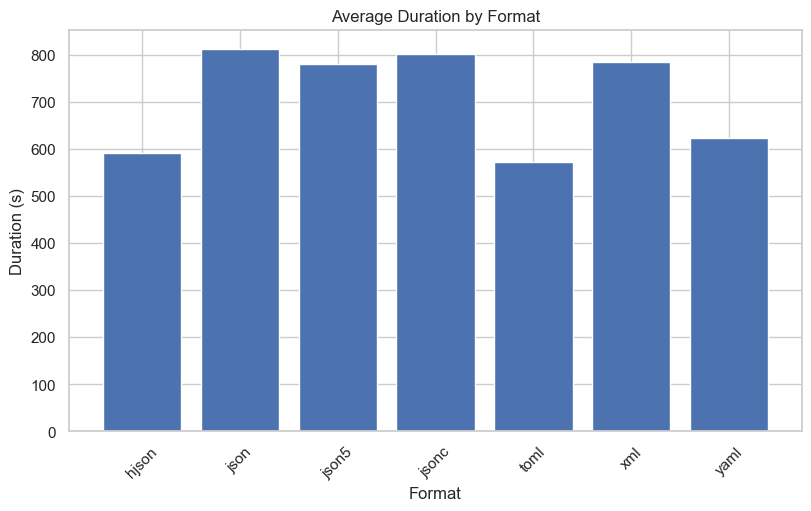

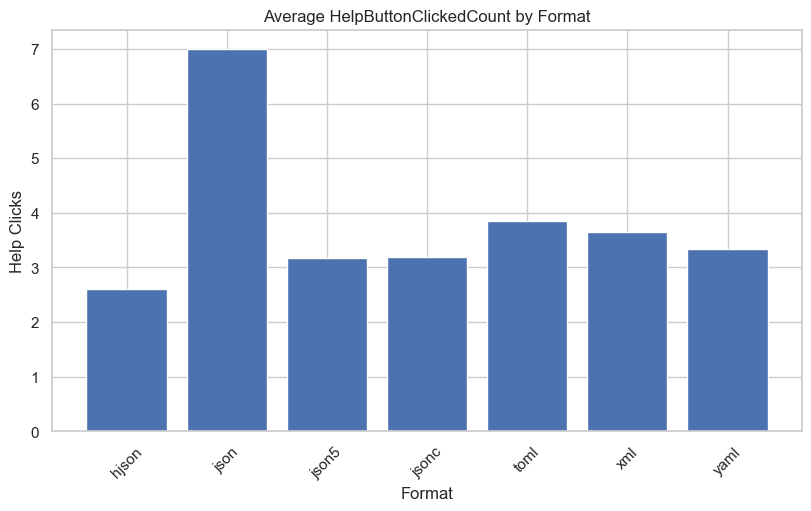

In [11]:
df_tabular = extract_writing_tabular_tasks(all_data, format_list=['hjson','json','xml','jsonc','json5', 'yaml', 'toml'])
fig_dur, fig_help = plot_tabular_metrics_by_format(
    df_tabular,
    format_list=['hjson','json','xml','jsonc','json5', 'yaml', 'toml']
)
fig_dur.show()
fig_help.show()
df_tabular.head(10)

In [16]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def test_format_differences(
    df: pd.DataFrame,
    metrics: list,
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    Compare specified numeric metrics across levels of `format_col`.

    Args:
      df         DataFrame containing at least [format_col] + metrics
      metrics    List of numeric column names to test, e.g. ['duration_sec','helpButtonClickedCount']
      format_col Name of the grouping column (default 'format')
      alpha      Significance threshold (default 0.05)

    Returns:
      A dict mapping each metric -> {
        'levene':        (W_stat, p_levene),
        'method':        'ANOVA' or 'Kruskal–Wallis',
        'stat':          F or H statistic,
        'p_value':       p-value of the test,
        'tukey':         TukeyHSDResults or None,
        'interpretation': human-readable summary
      }
    """
    results = {}
    for metric in metrics:
        if metric not in df.columns:
            print(f"⚠️ Column '{metric}' not in DataFrame; skipping.")
            continue

        # 1) Drop NA and coerce numeric
        series = pd.to_numeric(df[metric], errors='coerce')
        sub = pd.concat([df[format_col], series], axis=1).dropna()
        sub.columns = [format_col, metric]

        # 2) Build one array per format
        groups = [g[metric].values for _, g in sub.groupby(format_col)]
        if len(groups) < 2:
            print(f"⚠️ Metric '{metric}' has fewer than 2 formats; skipping.")
            continue

        # 3) Levene’s test
        W, p_levene = levene(*groups)

        # 4) Choose ANOVA vs Kruskal–Wallis
        if p_levene > alpha:
            stat, pval = f_oneway(*groups)
            method = 'ANOVA'
        else:
            try:
                stat, pval = kruskal(*groups)
            except ValueError:
                # all values identical → no difference
                stat, pval = 0.0, 1.0
            method = 'Kruskal–Wallis'

        # 5) Tukey HSD if ANOVA & significant
        tukey = None
        if method == 'ANOVA' and pval < alpha:
            tukey = pairwise_tukeyhsd(
                endog=sub[metric],
                groups=sub[format_col],
                alpha=alpha
            )

        # 6) Build interpretation
        hom = 'homogeneous' if p_levene > alpha else 'heterogeneous'
        var_msg = (f"Levene’s test for '{metric}': W = {W:.3f}, "
                   f"p = {p_levene:.3f} ({hom} variances).")
        if pval < alpha:
            main_msg = (f"{method}: statistic = {stat:.3f}, p = {pval:.3f} (< {alpha}), "
                        "formats differ significantly.")
            if tukey is not None:
                main_msg += " See Tukey HSD for pairwise comparisons."
        else:
            main_msg = (f"{method}: statistic = {stat:.3f}, p = {pval:.3f} (≥ {alpha}), "
                        "no significant differences between formats.")

        results[metric] = {
            'levene':        (W, p_levene),
            'method':        method,
            'stat':          stat,
            'p_value':       pval,
            'tukey':         tukey,
            'interpretation': var_msg + " " + main_msg
        }

    return results


results = test_format_differences(
    df_tabular,
    metrics=['duration_sec','helpButtonClickedCount'],
    format_col='format',
    alpha=0.05
)

for metric, info in results.items():
    print(f"\n=== Metric: {metric} ===")
    print(info['interpretation'])
    if info['tukey'] is not None:
        print(info['tukey'].summary())



=== Metric: duration_sec ===
Levene’s test for 'duration_sec': W = 0.355, p = 0.905 (homogeneous variances). ANOVA: statistic = 1.354, p = 0.241 (≥ 0.05), no significant differences between formats.

=== Metric: helpButtonClickedCount ===
Levene’s test for 'helpButtonClickedCount': W = 0.955, p = 0.460 (homogeneous variances). ANOVA: statistic = 0.766, p = 0.598 (≥ 0.05), no significant differences between formats.


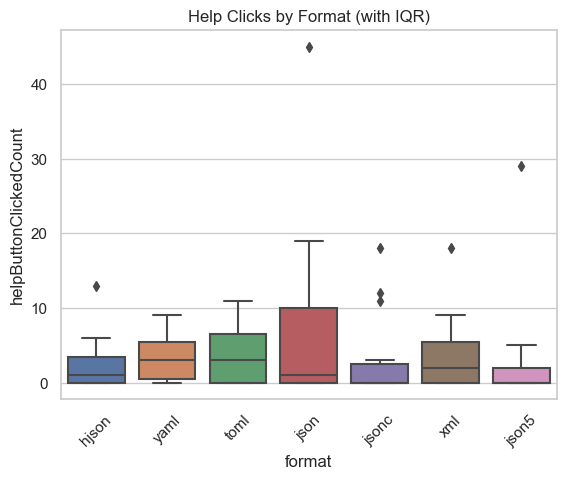

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='format', y='helpButtonClickedCount', data=df_tabular)
plt.xticks(rotation=45)
plt.title("Help Clicks by Format (with IQR)")
plt.show()


In [19]:
import pingouin as pg

# duration_sec 的置换 ANOVA
perm_dur = pg.permutation_anova(
    data=df_tabular, dv='duration_sec', between='format', seed=42, n_perm=5000
)
print(perm_dur)

# helpButtonClickedCount 的置换 ANOVA
perm_help = pg.permutation_anova(
    data=df_tabular, dv='helpButtonClickedCount', between='format', seed=42, n_perm=5000
)
print(perm_help)

ImportError: cannot import name 'studentized_range' from 'scipy.stats' (/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/__init__.py)

In [21]:
import statsmodels.formula.api as smf

# duration_sec 下的随机截距模型
md = smf.mixedlm("duration_sec ~ C(format)", df_tabular, 
                 groups=df_tabular["participantId"])
m1 = md.fit()
print(m1.summary())

# helpButtonClickedCount 同理
md2 = smf.mixedlm("helpButtonClickedCount ~ C(format)", df_tabular, 
                  groups=df_tabular["participantId"])
m2 = md2.fit()
print(m2.summary())


               Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    duration_sec
No. Observations:    102        Method:                REML        
No. Groups:          102        Scale:                 63254.0985  
Min. group size:     1          Log-Likelihood:        -702.1923   
Max. group size:     1          Converged:             Yes         
Mean group size:     1.0                                           
-------------------------------------------------------------------
                     Coef.   Std.Err.   z    P>|z|  [0.025   0.975]
-------------------------------------------------------------------
Intercept            592.195   91.836  6.448 0.000  412.199 772.190
C(format)[T.json]    220.448  125.998  1.750 0.080  -26.504 467.400
C(format)[T.json5]   189.286  137.754  1.374 0.169  -80.707 459.280
C(format)[T.jsonc]   208.765  129.876  1.607 0.108  -45.787 463.317
C(format)[T.toml]    -18.838  132.175 -0.143 0.887 -277.896 240

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [27]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import levene, f_oneway, kruskal, ttest_ind
from statsmodels.stats.multitest import multipletests

def test_format_differences_with_interpretation(
    df: pd.DataFrame,
    metrics: list,
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    For each metric, performs:
      1) Levene’s test → choose ANOVA or Kruskal
      2) Overall test statistics
      3) Pairwise Welch t-tests with Bonferroni correction
      4) Builds English interpretations for overall and pairwise results

    Returns a dict:
      metric -> {
        'overall': {
          'levene':   (W, p_levene),
          'method':   'ANOVA' or 'Kruskal',
          'stat':     F or H,
          'p_value':  p_overall,
          'interpretation': str
        },
        'pairwise': DataFrame with columns
          ['group1','group2','t_stat','p_raw','p_adj','reject','interpretation']
      }
    """
    results = {}

    for metric in metrics:
        if metric not in df.columns:
            print(f"⚠️ Column '{metric}' not found; skipping.")
            continue

        # prepare data
        ser = pd.to_numeric(df[metric], errors='coerce')
        sub = pd.concat([df[format_col], ser], axis=1).dropna()
        sub.columns = [format_col, metric]

        # overall groups
        groups = [g[metric].values for _, g in sub.groupby(format_col)]
        if len(groups) < 2:
            print(f"⚠️ Metric '{metric}' has <2 formats; skipping.")
            continue

        # Levene
        W, p_levene = levene(*groups)
        homogeneity = p_levene > alpha

        # overall test
        if homogeneity:
            stat, p_overall = f_oneway(*groups)
            method = 'ANOVA'
        else:
            try:
                stat, p_overall = kruskal(*groups)
            except ValueError:
                stat, p_overall = 0.0, 1.0
            method = 'Kruskal'

        # build overall interpretation
        overall_interp = (
            f"Levene’s test for '{metric}': W = {W:.3f}, "
            f"p = {p_levene:.3f} "
            f"({'variances homogeneous' if homogeneity else 'variances heterogeneous'}). "
            f"{method} result: statistic = {stat:.3f}, p = {p_overall:.3f}. "
        )
        if p_overall < alpha:
            overall_interp += "This indicates significant differences across formats."
        else:
            overall_interp += "No significant differences were found across formats."

        overall = {
            'levene':         (W, p_levene),
            'method':         method,
            'stat':           stat,
            'p_value':        p_overall,
            'interpretation': overall_interp
        }

        # pairwise Welch t-tests + Bonferroni
        pw_records = []
        for g1, g2 in combinations(sub[format_col].unique(), 2):
            x = sub.loc[sub[format_col] == g1, metric]
            y = sub.loc[sub[format_col] == g2, metric]
            t_stat, p_raw = ttest_ind(x, y, equal_var=False, nan_policy='omit')
            pw_records.append((g1, g2, t_stat, p_raw))

        if pw_records:
            df_pw = pd.DataFrame(pw_records,
                                 columns=['group1','group2','t_stat','p_raw'])
            reject, p_adj, _, _ = multipletests(df_pw['p_raw'], alpha=alpha, method='bonferroni')
            df_pw['p_adj']   = p_adj
            df_pw['reject']  = reject

            # add interpretation per pair
            def make_pair_interp(row):
                sig = "significant" if row['reject'] else "not significant"
                return (
                    f"Comparison {row['group1']} vs {row['group2']}: "
                    f"t = {row['t_stat']:.3f}, p_adj = {row['p_adj']:.3f} "
                    f"({sig})."
                )
            df_pw['interpretation'] = df_pw.apply(make_pair_interp, axis=1)
        else:
            df_pw = pd.DataFrame(columns=[
                'group1','group2','t_stat','p_raw','p_adj','reject','interpretation'
            ])

        results[metric] = {
            'overall':  overall,
            'pairwise': df_pw
        }

    return results



# 假设你的新 DataFrame 叫 df2，且含 ['format','duration_sec','helpButtonClickedCount',...]
metrics = ['duration_sec','helpButtonClickedCount']

res = test_format_overall_and_pairwise(
    df_tabular,
    metrics=metrics,
    format_col='format',
    alpha=0.05
)

# 打印结果
for metric, info in res.items():
    print(f"\n=== Metric: {metric} ===")
    ov = info['overall']
    print(f"Levene’s test: W={ov['levene'][0]:.3f}, p={ov['levene'][1]:.3f}")
    print(f"{ov['method']}: stat={ov['stat']:.3f}, p={ov['p_value']:.3f}")
    print("\nPairwise Welch t-tests (Bonferroni-adjusted):")
    print(info['pairwise'])




=== Metric: duration_sec ===
Levene’s test: W=0.355, p=0.905
ANOVA: stat=1.354, p=0.241

Pairwise Welch t-tests (Bonferroni-adjusted):
   group1 group2    t_stat     p_raw  p_adj  reject
0   hjson   yaml -0.245631  0.808046    1.0   False
1   hjson   toml  0.158378  0.875506    1.0   False
2   hjson   json -2.041800  0.050212    1.0   False
3   hjson  jsonc -1.630807  0.116201    1.0   False
4   hjson    xml -1.681231  0.105520    1.0   False
5   hjson  json5 -1.660513  0.111349    1.0   False
6    yaml   toml  0.346516  0.731644    1.0   False
7    yaml   json -1.418784  0.167100    1.0   False
8    yaml  jsonc -1.184134  0.246328    1.0   False
9    yaml    xml -1.166003  0.253880    1.0   False
10   yaml  json5 -1.143889  0.263507    1.0   False
11   toml   json -1.863669  0.073191    1.0   False
12   toml  jsonc -1.562605  0.129846    1.0   False
13   toml    xml -1.579083  0.126439    1.0   False
14   toml  json5 -1.558967  0.132099    1.0   False
15   json  jsonc  0.085377  0.93

In [28]:
def summarize_format_significance(
    df: pd.DataFrame,
    metrics: list,
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    For each numeric metric, performs:
      1) Levene’s test for equal variances across formats.
      2) If variances are homogeneous, one-way ANOVA; otherwise Kruskal–Wallis.
    Then returns a simple summary of whether formats differ significantly.

    Args:
      df         DataFrame containing at least [format_col] + metrics
      metrics    List of column names to test, e.g. ['duration_sec','helpButtonClickedCount']
      format_col Name of the grouping column (default 'format')
      alpha      Significance cutoff (default 0.05)

    Returns:
      A dict mapping each metric to a one-sentence English summary.
    """
    summaries = {}

    for metric in metrics:
        if metric not in df.columns:
            summaries[metric] = f"Metric '{metric}' not found in DataFrame."
            continue

        # prepare data
        data = pd.concat([
            df[[format_col]],
            pd.to_numeric(df[metric], errors='coerce').rename(metric)
        ], axis=1).dropna()

        groups = [g[metric].values for _, g in data.groupby(format_col)]
        if len(groups) < 2:
            summaries[metric] = (
                f"Metric '{metric}' has fewer than 2 formats; cannot compare."
            )
            continue

        # Levene’s test
        W, p_levene = levene(*groups)

        # choose ANOVA or Kruskal
        if p_levene > alpha:
            stat, pval = f_oneway(*groups)
            test_name = 'ANOVA'
        else:
            # handle constant or identical-value groups
            try:
                stat, pval = kruskal(*groups)
            except ValueError:
                stat, pval = 0.0, 1.0
            test_name = 'Kruskal–Wallis'

        # build summary sentence
        if pval < alpha:
            summaries[metric] = (
                f"For '{metric}', {test_name} p = {pval:.3f} (< {alpha}), "
                "formats differ significantly."
            )
        else:
            summaries[metric] = (
                f"For '{metric}', {test_name} p = {pval:.3f} (≥ {alpha}), "
                "no significant differences across formats."
            )

    return summaries
metrics = ['duration_sec', 'helpButtonClickedCount']

results = summarize_format_significance(
    df_tabular,
    metrics=metrics,
    format_col='format',
    alpha=0.05
)

for metric, summary in results.items():
    print(summary)

For 'duration_sec', ANOVA p = 0.241 (≥ 0.05), no significant differences across formats.
For 'helpButtonClickedCount', ANOVA p = 0.598 (≥ 0.05), no significant differences across formats.


## syntax check

In [30]:
from linter import plot_avg_total_changes_by_format, plot_syntax_pass_rates, analyze_tabular_writing_diff,batch_tree_distance_analysis, validate_tabular_syntax_all, summarize_syntax_pass_rates # 假设文件名就是 writing_tabular_analysis.py

from writing_evaluator import extract_writing_tabular_tasks
# —————————————————————————————————————————————
# 3. 方法一：简单严格语法校验
# —————————————————————————————————————————————
df_tab       = extract_writing_tabular_tasks(all_data)
df_checked = validate_tabular_syntax_all(
    df_tab,
    code_col='code',
    format_col='format',
    strict_col='syntax_strict',
    loose_col='syntax_loose',
    repair_col='syntax_repair'
)

print(df_checked.head())

summary_df = summarize_syntax_pass_rates(df_checked)
summary_df

              participantId format  \
0  6697c8b6d9d7baa7edd8c4d3  hjson   
1  67e25388d573ec2d5f1c8442   yaml   
2  67e5cf90b79d0874e1cf16b0   toml   
3  67d00f24466a67ba7e41228e   toml   
4  66475d6f7b27e4443ef0d031   json   

                                                code      startTime  \
0  patients: [\n    {\n        name: John\n      ...  1745932567200   
1  person:\n  name: John\ntests\n  # id:1\n  norm...  1746146837797   
2  [patients]\n[[patients.patient]]\nname = "John...  1746145745579   
3  [[patients]]\n[[users]]\nname = "john"\n[tests...  1745930601970   
4  {\n    patients\n    if(name)=John\n    then{\...  1744921480385   

         endTime  duration_sec  helpButtonClickedCount  syntax_strict  \
0  1745933142854       575.654                       0              1   
1  1746147375040       537.243                       2              0   
2  1746146463120       717.541                       2              1   
3  1745932342937      1740.967                      

,format,strict_pass_rate,loose_pass_rate,repair_pass_rate
0,hjson,0.400000,0.0,0.0
1,json,0.058824,0.0,0.0
2,json5,0.083333,0.0,0.0
3,jsonc,0.066667,0.0,0.0
4,toml,0.214286,0.0,0.0
5,xml,0.214286,0.0,0.0
6,yaml,0.466667,0.0,0.0


In [31]:
df_checked

,participantId,format,code,startTime,endTime,duration_sec,helpButtonClickedCount,syntax_strict,syntax_loose,syntax_repair
0,6697c8b6d9d7baa7edd8c4d3,hjson,patients: [\n {\n name: John\n ...,1745932567200,1745933142854,575.654,0,1,<NA>,<NA>
1,67e25388d573ec2d5f1c8442,yaml,person:\n name: John\ntests\n # id:1\n norm...,1746146837797,1746147375040,537.243,2,0,0,0
2,67e5cf90b79d0874e1cf16b0,toml,"[patients]\n[[patients.patient]]\nname = ""John...",1746145745579,1746146463120,717.541,2,1,<NA>,<NA>
3,67d00f24466a67ba7e41228e,toml,"[[patients]]\n[[users]]\nname = ""john""\n[tests...",1745930601970,1745932342937,1740.967,11,0,0,0
4,66475d6f7b27e4443ef0d031,json,{\n patients\n if(name)=John\n then{\...,1744921480385,1744921734203,253.818,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
97,67ab650c320eccf6141d4010,jsonc,"""name"" John""\n""id"": 2\n""results"" ""normal""\n""id...",1746146024272,1746147272533,1248.261,3,0,0,0
98,65fad673a546ab14baf2f8d3,json5,"{\n patients: {\n {\n name:'John',\n ...",1745930426793,1745931203100,776.307,0,0,0,0
99,67f1c7bd6f1c4a3d8deae02f,toml,"penalities = [""name"",""tests"",treatment]\ntreat...",1746145051620,1746145550967,499.347,0,0,0,0
100,67adb27bd5f5776fcb16da62,hjson,patients: [\n\n{\nname: John \ntests : [\n ...,1746146238628,1746146764449,525.821,0,0,0,0


In [33]:
import pandas as pd
from scipy.stats import chi2_contingency

def test_syntax_by_format(
    df: pd.DataFrame,
    format_col: str = 'format',
    alpha: float = 0.05
) -> dict:
    """
    对三个阶段 (syntax_strict, syntax_loose, syntax_repair)：
      1. 按 eligibility 筛行
      2. 构建 format × {0,1} 的交叉表
      3. 平滑：全表加 0.5，避免 0 期望
      4. 卡方检验 (Yates 校正)
      5. 输出检验统计量和一句英文解读
    """
    results = {}
    stages = [
        ('syntax_strict',        None),
        ('syntax_loose',  lambda d: d['syntax_strict'] == 0),
        ('syntax_repair', lambda d: d['syntax_loose'] == 0)
    ]

    for var, eligible in stages:
        # 1) 筛出 eligible 行
        sub = df if eligible is None else df[eligible(df)]
        sub = sub[[format_col, var]].dropna()
        sub = sub[sub[var].isin([0,1])]
        if sub.empty:
            results[var] = {
                'contingency': None,
                'chi2': None,
                'p_value': None,
                'dof': None,
                'interpretation': f"No data for {var}."
            }
            continue

        # 2) 构建表格
        ct = pd.crosstab(sub[format_col], sub[var])
        # 确保 0/1 列都存在
        for col in (0,1):
            if col not in ct.columns:
                ct[col] = 0
        ct = ct[[0,1]]

        # 3) 平滑 + 卡方
        ct_sm = ct + 0.5
        chi2, p, dof, _ = chi2_contingency(ct_sm.values, correction=True)

        # 4) 解读
        if p < alpha:
            interp = (
                f"For '{var}', χ² = {chi2:.3f}, p = {p:.3f} (< {alpha}), "
                "pass rates differ significantly by format."
            )
        else:
            interp = (
                f"For '{var}', χ² = {chi2:.3f}, p = {p:.3f} (≥ {alpha}), "
                "no significant difference in pass rates by format."
            )

        results[var] = {
            'contingency': ct,
            'chi2': chi2,
            'p_value': p,
            'dof': dof,
            'interpretation': interp
        }

    return results

res = test_syntax_by_format(df_checked, format_col='format')

for stage, info in res.items():
    print(f"\n=== {stage} ===")
    if info['contingency'] is not None:
        print("Contingency table (fail=0 / pass=1):")
        print(info['contingency'])
    print(info['interpretation'])



=== syntax_strict ===
Contingency table (fail=0 / pass=1):
syntax_strict   0  1
format              
hjson           9  6
json           16  1
json5          11  1
jsonc          14  1
toml           11  3
xml            11  3
yaml            8  7
For 'syntax_strict', χ² = 12.626, p = 0.049 (< 0.05), pass rates differ significantly by format.

=== syntax_loose ===
Contingency table (fail=0 / pass=1):
syntax_loose   0  1
format             
hjson          9  0
json          16  0
json5         11  0
jsonc         14  0
toml          11  0
xml           11  0
yaml           8  0
For 'syntax_loose', χ² = 0.151, p = 1.000 (≥ 0.05), no significant difference in pass rates by format.

=== syntax_repair ===
Contingency table (fail=0 / pass=1):
syntax_repair   0  1
format              
hjson           9  0
json           16  0
json5          11  0
jsonc          14  0
toml           11  0
xml            11  0
yaml            8  0
For 'syntax_repair', χ² = 0.151, p = 1.000 (≥ 0.05), no signifi

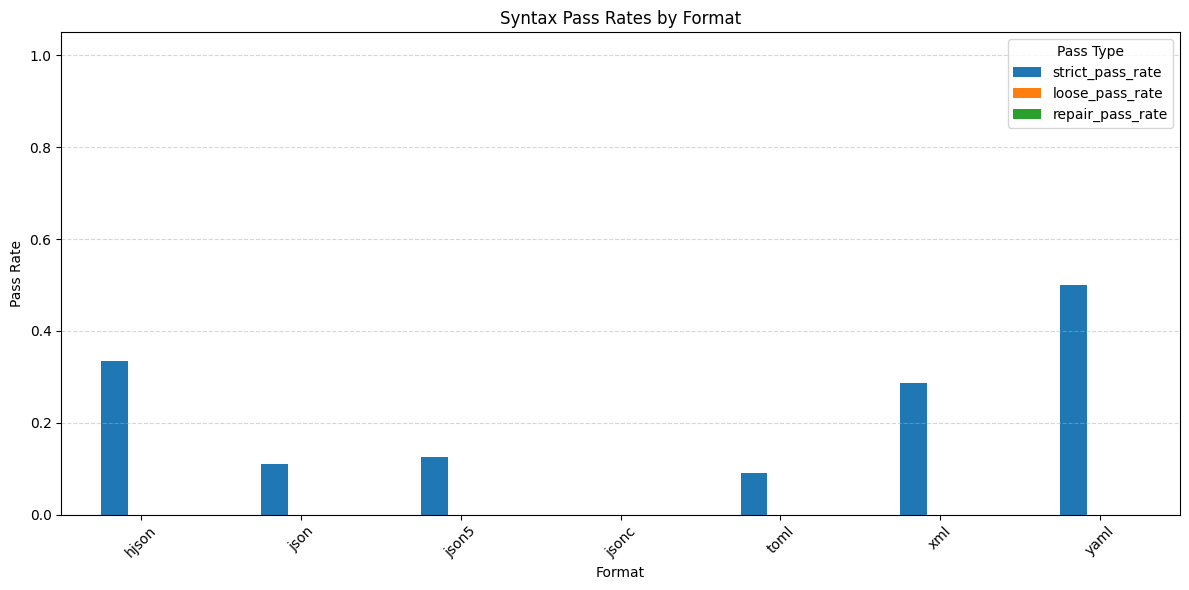

In [3]:
# 可视化语法通过率
plot_syntax_pass_rates(summary_df)

## git diff

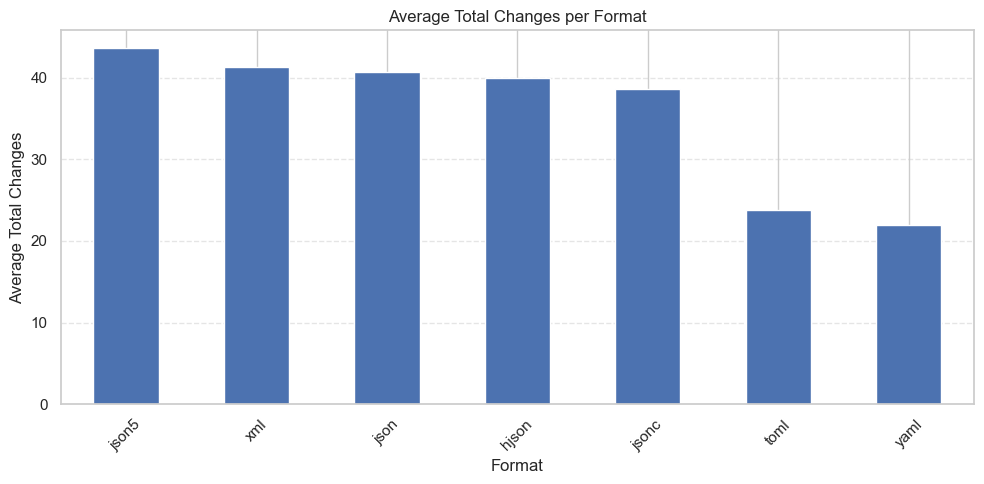

,participantId,format,task,syntax_valid,num_added_lines,num_removed_lines,total_changes,diff_text
0,6697c8b6d9d7baa7edd8c4d3,hjson,writing-task-tabular-hjson,1,21,24,45,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
1,67e25388d573ec2d5f1c8442,yaml,writing-task-tabular-yaml,0,16,12,28,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
2,67e5cf90b79d0874e1cf16b0,toml,writing-task-tabular-toml,1,13,13,26,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
3,67d00f24466a67ba7e41228e,toml,writing-task-tabular-toml,0,10,18,28,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
4,66475d6f7b27e4443ef0d031,json,writing-task-tabular-json,0,14,24,38,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
...,...,...,...,...,...,...,...,...
97,67ab650c320eccf6141d4010,jsonc,writing-task-tabular-jsonc,0,10,27,37,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
98,65fad673a546ab14baf2f8d3,json5,writing-task-tabular-json5,0,13,21,34,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
99,67f1c7bd6f1c4a3d8deae02f,toml,writing-task-tabular-toml,0,7,19,26,diff --git a/var/folders/hs/htjkkv116fv94g1llc...
100,67adb27bd5f5776fcb16da62,hjson,writing-task-tabular-hjson,0,11,25,36,diff --git a/var/folders/hs/htjkkv116fv94g1llc...


In [35]:

# —————————————————————————————————————————————
# 5. 方法三：git-diff 差异统计
# —————————————————————————————————————————————
# 准备你的标准答案 dict
correct_tabular_data = {
  "patients": [
    {"name":"John","tests":[{"id":1,"result":"Normal"},{"id":2,"result":"Elevated Cholesterol"}]},
    {"name":"Michael","tests":[{"id":1,"result":"Normal"}],"treatment":"Regular Monitoring"}
  ]
}


df_diff = analyze_tabular_writing_diff(all_data, correct_tabular_data)
plot_avg_total_changes_by_format(df_diff)
df_diff

In [36]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal

def test_total_changes_by_format(
    df: pd.DataFrame,
    format_col: str = 'format',
    value_col: str = 'total_changes',
    alpha: float = 0.05
) -> None:
    """
    对 df 中各 format 分组后的 total_changes 做：
      1) Levene 方差齐性检验
      2) ANOVA 或 Kruskal–Wallis
      3) 输出统计结果和一句中文解读
    """
    # 1) 准备各组数组
    data = df[[format_col, value_col]].dropna()
    groups = [g[value_col].values for _, g in data.groupby(format_col)]
    if len(groups) < 2:
        print("不足两个格式组，无法比较。")
        return

    # 2) Levene 检验
    W, p_levene = levene(*groups)
    print(f"Levene 方差齐性检验：W = {W:.3f}, p = {p_levene:.3f}")
    
    # 3) 依据方差齐性选取检验
    if p_levene > alpha:
        stat, pval = f_oneway(*groups)
        method = 'One-way ANOVA'
    else:
        stat, pval = kruskal(*groups)
        method = 'Kruskal–Wallis'
    
    print(f"{method}：stat = {stat:.3f}, p = {pval:.3f}")
    
    # 4) 中文解读
    if pval < alpha:
        print(f"→ p < {alpha:.2f}，不同格式组间 `total_changes` 存在显著差异。")
    else:
        print(f"→ p ≥ {alpha:.2f}，不同格式组间 `total_changes` 无显著差异。")

# 使用示例
# 假设你的 DataFrame 叫 df_changes，并已有列 ['format','total_changes']
test_total_changes_by_format(df_diff)


Levene 方差齐性检验：W = 3.820, p = 0.002
Kruskal–Wallis：stat = 59.781, p = 0.000
→ p < 0.05，不同格式组间 `total_changes` 存在显著差异。


In [37]:
import pandas as pd
import numpy as np
from scipy.stats import levene, f_oneway, kruskal, ttest_ind, mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def detailed_total_changes_by_format(
    df: pd.DataFrame,
    format_col: str = 'format',
    value_col: str = 'total_changes',
    alpha: float = 0.05
) -> None:
    """
    1) Levene 方差齐性检验
    2) ANOVA 或 Kruskal–Wallis 整体检验
    3) 如果用 ANOVA → Tukey HSD 事后比较
       否则用 Mann–Whitney U（两两）+ Bonferroni 校正
    4) 打印整体结果和每一对格式的 p-value 及显著性解读
    """
    data = df[[format_col, value_col]].dropna()
    groups = [g[value_col].values for _, g in data.groupby(format_col)]
    labels = data[format_col].unique().tolist()
    if len(labels) < 2:
        print("格式不足两类，无法比较。")
        return

    # 1) Levene
    W, p_levene = levene(*groups)
    print(f"Levene 方差齐性检验：W = {W:.3f}, p = {p_levene:.3f}")

    # 2) 整体检验
    if p_levene > alpha:
        stat, p_overall = f_oneway(*groups)
        method = 'ANOVA'
    else:
        try:
            stat, p_overall = kruskal(*groups)
        except ValueError:
            stat, p_overall = 0.0, 1.0
        method = 'Kruskal–Wallis'

    print(f"{method} 整体检验：stat = {stat:.3f}, p = {p_overall:.3f}")
    if p_overall < alpha:
        print(f"→ 整体 p < {alpha:.2f}，说明组间存在显著差异，下面看事后两两比较：\n")
    else:
        print(f"→ 整体 p ≥ {alpha:.2f}，说明组间无显著差异，但以下仍列出两两比较：\n")

    # 3) 事后两两比较
    if method == 'ANOVA':
        # Tukey HSD
        tukey = pairwise_tukeyhsd(
            endog=data[value_col],
            groups=data[format_col],
            alpha=alpha
        )
        print(tukey.summary())
    else:
        # Mann–Whitney U + Bonferroni
        records = []
        for f1, f2 in combinations(labels, 2):
            x = data.loc[data[format_col] == f1, value_col]
            y = data.loc[data[format_col] == f2, value_col]
            # two-sided Mann-Whitney U
            u, p_raw = mannwhitneyu(x, y, alternative='two-sided')
            records.append((f1, f2, u, p_raw))
        df_pw = pd.DataFrame(records,
                             columns=['format1','format2','U_stat','p_raw'])
        # Bonferroni 校正
        reject, p_adj, _, _ = multipletests(df_pw['p_raw'],
                                            alpha=alpha,
                                            method='bonferroni')
        df_pw['p_adj'] = p_adj
        df_pw['significant'] = reject

        # 打印表格
        print("Mann–Whitney U 两两比较 (Bonferroni 校正)：")
        for _, row in df_pw.iterrows():
            sig = "显著" if row['significant'] else "不显著"
            print(
                f"  {row['format1']} vs {row['format2']}: "
                f"U = {row['U_stat']:.2f}, p_adj = {row['p_adj']:.3f} → {sig}"
            )

detailed_total_changes_by_format(df_diff)

Levene 方差齐性检验：W = 3.820, p = 0.002
Kruskal–Wallis 整体检验：stat = 59.781, p = 0.000
→ 整体 p < 0.05，说明组间存在显著差异，下面看事后两两比较：

Mann–Whitney U 两两比较 (Bonferroni 校正)：
  hjson vs yaml: U = 220.00, p_adj = 0.000 → 显著
  hjson vs toml: U = 200.50, p_adj = 0.001 → 显著
  hjson vs json: U = 130.00, p_adj = 1.000 → 不显著
  hjson vs jsonc: U = 133.50, p_adj = 1.000 → 不显著
  hjson vs xml: U = 101.00, p_adj = 1.000 → 不显著
  hjson vs json5: U = 80.00, p_adj = 1.000 → 不显著
  yaml vs toml: U = 74.00, p_adj = 1.000 → 不显著
  yaml vs json: U = 0.00, p_adj = 0.000 → 显著
  yaml vs jsonc: U = 0.50, p_adj = 0.000 → 显著
  yaml vs xml: U = 0.50, p_adj = 0.000 → 显著
  yaml vs json5: U = 0.00, p_adj = 0.000 → 显著
  toml vs json: U = 0.00, p_adj = 0.000 → 显著
  toml vs jsonc: U = 4.00, p_adj = 0.000 → 显著
  toml vs xml: U = 3.50, p_adj = 0.000 → 显著
  toml vs json5: U = 2.50, p_adj = 0.001 → 显著
  json vs jsonc: U = 155.00, p_adj = 1.000 → 不显著
  json vs xml: U = 116.00, p_adj = 1.000 → 不显著
  json vs json5: U = 101.00, p_adj = 1.000 → 不显著


## tree dif

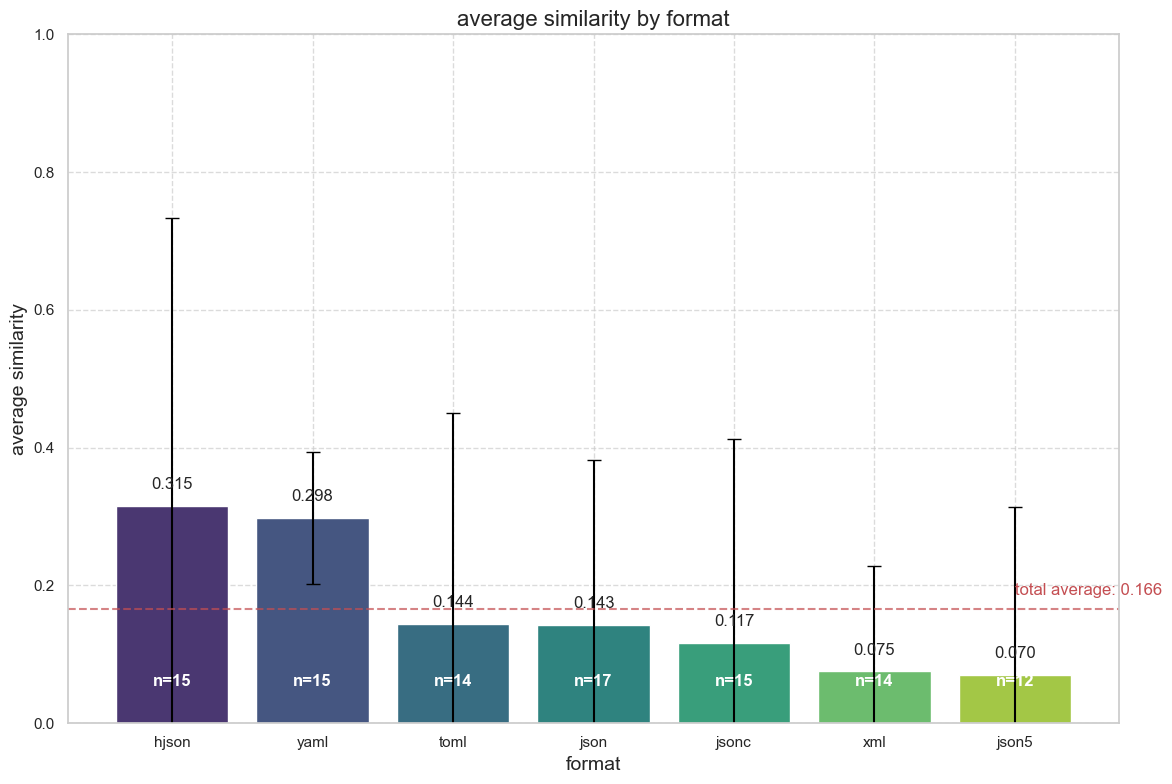

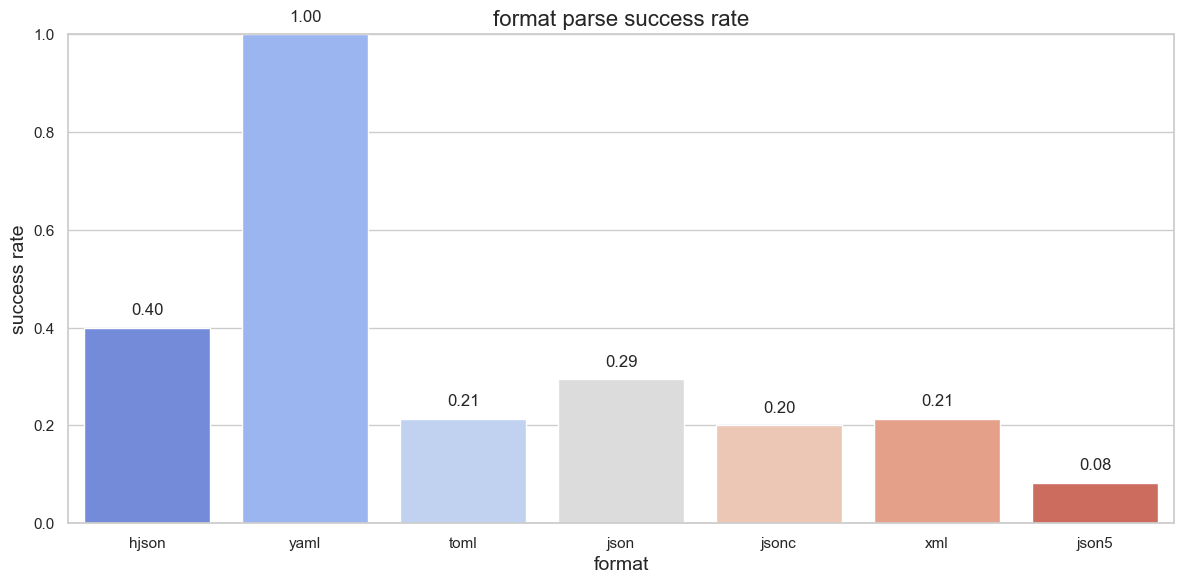

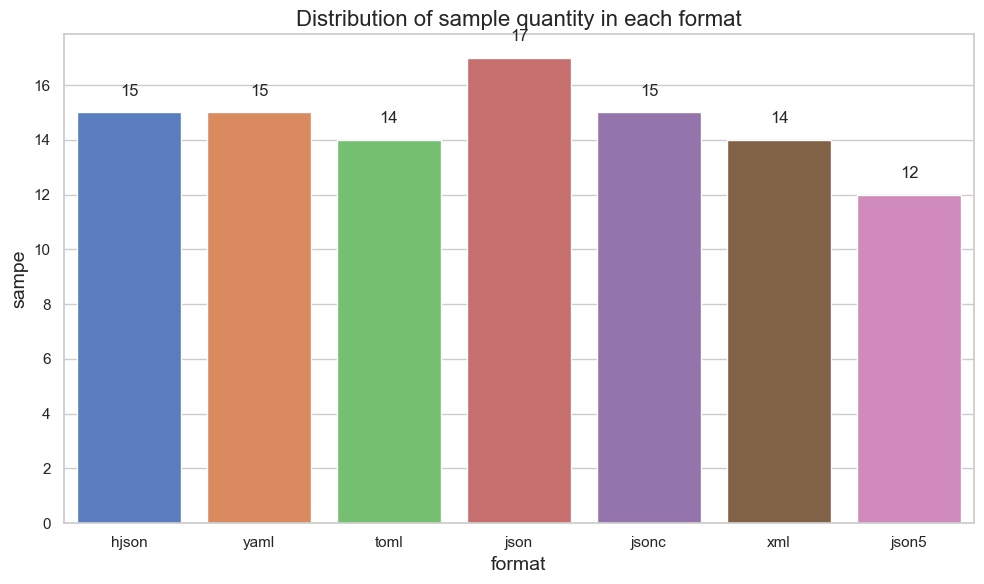

,similarity_score_mean,similarity_score_std,similarity_score_count,similarity_score_min,similarity_score_max,normalized_ted_mean,normalized_ted_std,normalized_ted_min,normalized_ted_max,error_<lambda>,success_rate
format,,,,,,,,,,,
hjson,0.315080,0.419063,15,0.0000,1.0000,0.831633,0.307371,0.2148,1.0000,9,0.400000
yaml,0.297893,0.096079,15,0.0519,0.4222,0.695320,0.127608,0.5704,0.9852,0,1.000000
toml,0.143886,0.306451,14,0.0000,0.8974,0.842200,0.332537,0.0652,1.0000,11,0.214286
json,0.143029,0.238595,17,0.0000,0.7037,0.854900,0.242334,0.2963,1.0000,12,0.294118
jsonc,0.117040,0.296036,15,0.0000,0.8741,0.882960,0.296036,0.1259,1.0000,12,0.200000
xml,0.075186,0.153652,14,0.0000,0.4564,0.913893,0.185543,0.3871,1.0000,11,0.214286
json5,0.070367,0.243757,12,0.0000,0.8444,0.931483,0.237349,0.1778,1.0000,11,0.083333


In [38]:
from linter import batch_tree_distance_analysis_tree_only,visualize_format_similarity,calculate_format_similarity_stats
correct_tabular_data = {
  "patients": [
    {"name": "John", "tests": [{"id": 1, "result": "Normal"}, {"id": 2, "result": "Elevated Cholesterol"}]},
    {"name": "Michael", "tests": [{"id": 1, "result": "Normal"}], "treatment": "Regular Monitoring"}
  ]
}

# 调用函数（传入你的 all_data 和标准答案对象）
df_ted = batch_tree_distance_analysis_tree_only(all_data, correct_tabular_data)

# 你的 ground truth 数据（结构化 JSON 对象）
df_stats=calculate_format_similarity_stats(df_ted)
visualize_format_similarity(df_stats)
df_stats

In [39]:
df_ted[df_ted['format'] == 'yaml'].head(10)

,participantId,format,task,ted,normalized_ted,similarity_score,gold_tree_size,user_tree_size,error
0,6697c8b6d9d7baa7edd8c4d3,hjson,writing-task-tabular-hjson,52.0,0.3796,0.6429,135.0,137.0,None
1,67e25388d573ec2d5f1c8442,yaml,writing-task-tabular-yaml,111.0,0.8222,0.1778,135.0,34.0,None
2,67e5cf90b79d0874e1cf16b0,toml,writing-task-tabular-toml,88.0,0.5867,0.3566,135.0,150.0,None
3,67d00f24466a67ba7e41228e,toml,writing-task-tabular-toml,NaN,1.0000,0.0000,NaN,NaN,解析失败 (json/toml): 转换格式 toml 到 JSON 失败: Unbalan...
4,66475d6f7b27e4443ef0d031,json,writing-task-tabular-json,NaN,1.0000,0.0000,NaN,NaN,解析失败 (json/json): 转换格式 json 到 JSON 失败: 无法解析JSO...
...,...,...,...,...,...,...,...,...,...
97,67ab650c320eccf6141d4010,jsonc,writing-task-tabular-jsonc,NaN,1.0000,0.0000,NaN,NaN,解析失败 (json/jsonc): 转换格式 jsonc 到 JSON 失败: Extra...
98,65fad673a546ab14baf2f8d3,json5,writing-task-tabular-json5,NaN,1.0000,0.0000,NaN,NaN,解析失败 (json/json5): 转换格式 json5 到 JSON 失败: <stri...
99,67f1c7bd6f1c4a3d8deae02f,toml,writing-task-tabular-toml,NaN,1.0000,0.0000,NaN,NaN,解析失败 (json/toml): 转换格式 toml 到 JSON 失败: This fl...
100,67adb27bd5f5776fcb16da62,hjson,writing-task-tabular-hjson,NaN,1.0000,0.0000,NaN,NaN,解析失败 (json/hjson): 转换格式 hjson 到 JSON 失败: Extra...


In [41]:
import pandas as pd
from scipy.stats import levene, f_oneway, kruskal, chi2_contingency

def test_similarity_and_parse_success(
    df: pd.DataFrame,
    format_col: str = 'format',
    similarity_col: str = 'similarity_score',
    error_col: str = 'error',
    alpha: float = 0.05
) -> dict:
    """
    1. Create `parse_success` = 1 if error is None, else 0.
    2. Test numeric `similarity_score` across formats:
       - Levene → ANOVA or Kruskal
       - Return statistic, p and interpretation.
    3. Test binary `parse_success` across formats:
       - Build contingency table format×{0,1}, add 0.5 smoothing
       - Chi-square test with Yates correction
       - Return chi2, p and interpretation.
    """
    results = {}

    # 1) 生成 parse_success
    df = df.copy()
    df['parse_success'] = df[error_col].isna().astype(int)

    # 2) 数值检验：similarity_score
    sim = pd.to_numeric(df[similarity_col], errors='coerce')
    sub_sim = df[[format_col]].join(sim).dropna()
    groups = [g[similarity_col].values for _, g in sub_sim.groupby(format_col)]
    if len(groups) < 2:
        sim_interp = "Not enough formats to compare similarity_score."
    else:
        W, p_levene = levene(*groups)
        if p_levene > alpha:
            stat, pval = f_oneway(*groups)
            test = 'ANOVA'
        else:
            try:
                stat, pval = kruskal(*groups)
            except ValueError:
                stat, pval = 0.0, 1.0
            test = 'Kruskal–Wallis'

        if pval < alpha:
            sim_interp = (
                f"Similarity score: {test} p = {pval:.3f} (<{alpha}), "
                "formats differ significantly."
            )
        else:
            sim_interp = (
                f"Similarity score: {test} p = {pval:.3f} (≥{alpha}), "
                "no significant differences across formats."
            )

    results['similarity_score'] = {
        'interpretation': sim_interp
    }

    # 3) 二分类检验：parse_success
    sub_ps = df[[format_col,'parse_success']].dropna()
    ct = pd.crosstab(sub_ps[format_col], sub_ps['parse_success'])
    # 确保 0/1 两列
    for col in (0,1):
        if col not in ct.columns:
            ct[col] = 0
    ct = ct[[0,1]]
    # 平滑
    ct_s = ct + 0.5
    try:
        chi2, p_ps, dof, _ = chi2_contingency(ct_s.values, correction=True)
    except ValueError:
        chi2, p_ps, dof = 0.0, 1.0, None

    if p_ps < alpha:
        ps_interp = (
            f"Parse success: χ² = {chi2:.3f}, p = {p_ps:.3f} (<{alpha}), "
            "success rate differs significantly by format."
        )
    else:
        ps_interp = (
            f"Parse success: χ² = {chi2:.3f}, p = {p_ps:.3f} (≥{alpha}), "
            "no significant difference in success rate by format."
        )

    results['parse_success'] = {
        'contingency': ct,
        'chi2': chi2,
        'p_value': p_ps,
        'interpretation': ps_interp
    }

    return results

# 假设你的 DataFrame 叫 df_ted，含 ['format','similarity_score','error',...]
res = test_similarity_and_parse_success(df_ted)

print(res['similarity_score']['interpretation'])
print(res['parse_success']['interpretation'])


Similarity score: ANOVA p = 0.074 (≥0.05), no significant differences across formats.
Parse success: χ² = 35.071, p = 0.000 (<0.05), success rate differs significantly by format.


In [42]:
import pandas as pd
from itertools import combinations
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests

def pairwise_parse_success(
    df: pd.DataFrame,
    format_col: str = 'format',
    error_col: str = 'error',
    alpha: float = 0.05,
    correction: str = 'bonferroni'
) -> pd.DataFrame:
    """
    对 df 中每对 format 进行 parse_success 比例差异的两组 z 检验，
    并用 Bonferroni（或其它）法校正多重比较。

    Returns a DataFrame with columns:
      ['format1','format2','success1','n1','success2','n2',
       'z_stat','p_raw','p_adj','reject'].
    """
    # 1. 生成 parse_success
    df = df.copy()
    df['parse_success'] = df[error_col].isna().astype(int)

    # 2. 统计每个 format 的 成功数 和 样本数
    agg = df.groupby(format_col)['parse_success'] \
            .agg(success='sum', n='count') \
            .reset_index()
    formats = agg[format_col].tolist()

    # 3. 对每一对 format 做 proportions_ztest
    records = []
    for f1, f2 in combinations(formats, 2):
        s1 = agg.loc[agg[format_col]==f1, 'success'].iloc[0]
        n1 = agg.loc[agg[format_col]==f1, 'n'].iloc[0]
        s2 = agg.loc[agg[format_col]==f2, 'success'].iloc[0]
        n2 = agg.loc[agg[format_col]==f2, 'n'].iloc[0]
        # 2-sample z-test for proportions
        stat, p_raw = proportions_ztest([s1, s2], [n1, n2], alternative='two-sided')
        records.append((f1, f2, s1, n1, s2, n2, stat, p_raw))

    df_pw = pd.DataFrame(
        records,
        columns=['format1','format2','success1','n1','success2','n2','z_stat','p_raw']
    )

    # 4. 多重比较校正
    reject, p_adj, _, _ = multipletests(df_pw['p_raw'], alpha=alpha, method=correction)
    df_pw['p_adj'] = p_adj
    df_pw['reject'] = reject

    return df_pw

# 假设你的 DataFrame 叫 df_ted，含 ['format','error',…]
df_pairs = pairwise_parse_success(df_ted, format_col='format', error_col='error')

# 打印结果
print("Pairwise parse_success comparisons (Bonferroni-adjusted):")
print(df_pairs.to_string(index=False))

# 英文解读示例
for _, row in df_pairs.iterrows():
    sig = "significant" if row.reject else "not significant"
    print(
        f"{row.format1} vs {row.format2}: "
        f"z = {row.z_stat:.3f}, p_adj = {row.p_adj:.3f} → {sig} difference in parse_success."
    )


Pairwise parse_success comparisons (Bonferroni-adjusted):
format1 format2  success1  n1  success2  n2    z_stat    p_raw    p_adj  reject
  hjson    json         3  15         5  17 -0.613572 0.539498 1.000000   False
  hjson   json5         3  15         1  12  0.847951 0.396465 1.000000   False
  hjson   jsonc         3  15         3  15  0.000000 1.000000 1.000000   False
  hjson    toml         3  15         3  14 -0.094901 0.924393 1.000000   False
  hjson     xml         3  15         3  14 -0.094901 0.924393 1.000000   False
  hjson    yaml         3  15        15  15 -4.472136 0.000008 0.000163    True
   json   json5         5  17         1  12  1.380107 0.167554 1.000000   False
   json   jsonc         5  17         3  15  0.613572 0.539498 1.000000   False
   json    toml         5  17         3  14  0.505519 0.613195 1.000000   False
   json     xml         5  17         3  14  0.505519 0.613195 1.000000   False
   json    yaml         5  17        15  15 -4.115966 0.000039

In [43]:
import pandas as pd
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def pairwise_similarity_by_format(
    df: pd.DataFrame,
    format_col: str = 'format',
    similarity_col: str = 'similarity_score',
    alpha: float = 0.05,
    correction: str = 'bonferroni'
) -> pd.DataFrame:
    """
    Perform pairwise comparisons of similarity_score across formats:
      - For each pair of formats, do a Welch's t-test (unequal variances).
      - Collect raw p-values, then apply a multiple-testing correction.
    Returns a DataFrame with:
      format1, format2, mean1, mean2, t_stat, p_raw, p_adj, reject
    """

    # 1) 聚合同一个格式的所有相似度并计算均值和样本
    agg = (
        df
        .groupby(format_col)[similarity_col]
        .agg(mean_similarity='mean', n='count')
        .reset_index()
    )
    formats = agg[format_col].tolist()

    # 2) 对每对格式做 Welch t-test
    records = []
    for f1, f2 in combinations(formats, 2):
        x = df.loc[df[format_col] == f1, similarity_col].dropna().values
        y = df.loc[df[format_col] == f2, similarity_col].dropna().values
        # 需要至少各自有 2 个观测
        if len(x) < 2 or len(y) < 2:
            continue
        t_stat, p_raw = ttest_ind(x, y, equal_var=False, nan_policy='omit')
        m1 = x.mean()
        m2 = y.mean()
        records.append((f1, f2, m1, m2, t_stat, p_raw))

    if not records:
        raise ValueError("Not enough data to compare any pair of formats.")

    df_pw = pd.DataFrame(
        records,
        columns=[
            'format1','format2',
            'mean1','mean2',
            't_stat','p_raw'
        ]
    )

    # 3) 多重比较校正
    reject, p_adj, _, _ = multipletests(df_pw['p_raw'], alpha=alpha, method=correction)
    df_pw['p_adj']   = p_adj
    df_pw['reject']  = reject

    return df_pw

# 假设你的 DataFrame 叫 df_ted，含 ['format','similarity_score',...]
df_sim_pw = pairwise_similarity_by_format(
    df_ted,
    format_col='format',
    similarity_col='similarity_score',
    alpha=0.05
)

print("Pairwise similarity comparisons (Bonferroni-adjusted):")
print(df_sim_pw.to_string(index=False))

# 生成一句英文解读
for _, row in df_sim_pw.iterrows():
    sig = "significant" if row.reject else "not significant"
    print(
        f"{row.format1} (mean={row.mean1:.3f}) vs "
        f"{row.format2} (mean={row.mean2:.3f}): "
        f"t = {row.t_stat:.3f}, p_adj = {row.p_adj:.3f} → {sig}."
    )


Pairwise similarity comparisons (Bonferroni-adjusted):
format1 format2    mean1    mean2    t_stat    p_raw    p_adj  reject
  hjson    json 0.315080 0.143029  1.402161 0.175071 1.000000   False
  hjson   json5 0.315080 0.070367  1.895976 0.070547 1.000000   False
  hjson   jsonc 0.315080 0.117040  1.494905 0.147364 1.000000   False
  hjson    toml 0.315080 0.143886  1.261528 0.218497 1.000000   False
  hjson     xml 0.315080 0.075186  2.072842 0.052885 1.000000   False
  hjson    yaml 0.315080 0.297893  0.154822 0.878964 1.000000   False
   json   json5 0.143029 0.070367  0.797570 0.433100 1.000000   False
   json   jsonc 0.143029 0.117040  0.271089 0.788391 1.000000   False
   json    toml 0.143029 0.143886 -0.008539 0.993257 1.000000   False
   json     xml 0.143029 0.075186  0.956112 0.347325 1.000000   False
   json    yaml 0.143029 0.297893 -2.459680 0.022407 0.470548   False
  json5   jsonc 0.070367 0.117040 -0.449240 0.657134 1.000000   False
  json5    toml 0.070367 0.143886 -